I'd like to look at the gene expression results in a basic way, perhaps look for outliers
or things that don't look like iPSCs. Then I'll filter genes to come up with a set
I want to use for identifying eQTLs.

In [1]:
import os
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import svd
import scipy.stats as stats
import seaborn as sns

import cardipspy as cpy
import ciepy

%matplotlib inline

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
array_meta = pd.read_table(os.path.join(ciepy.root, 'data', 'array_metadata.tsv'), index_col=0)
wgs_meta = pd.read_table(os.path.join(ciepy.root, 'data', 'wgs_metadata.tsv'), index_col=0, 
                         squeeze=True)
rna_meta = pd.read_table(os.path.join(ciepy.root, 'data', 'rnaseq_metadata.tsv'), index_col=0)

#vsd = pd.read_table(os.path.join(cpy.root, 'output', 'rna_seq_processing', 
#                                 'vst_counts.tsv'), index_col=0)
tpm = pd.read_table(os.path.join(ciepy.root, 'data', 'rsem_tpm.tsv'), index_col=0,
                                 low_memory=False)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

## Expression Distribution

202    20897
0      15241
dtype: int64


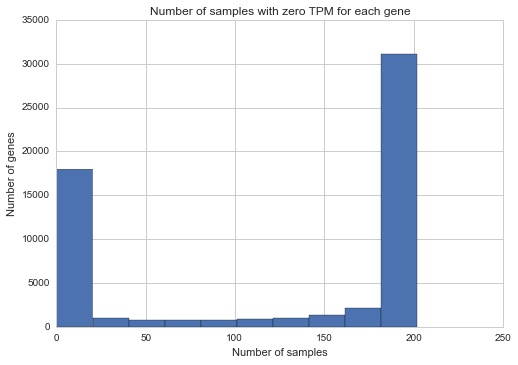

In [4]:
s = (tpm == 0).sum(axis=1)
print(s.value_counts().head(2))
s.hist()
plt.title('Number of samples with zero TPM for each gene')
plt.ylabel('Number of genes')
plt.xlabel('Number of samples');

We can see overal that there are a fair number of genes that are not expressed
in any samples.

0      13567
202      984
dtype: int64


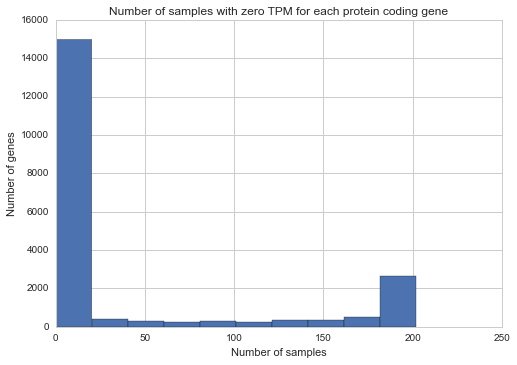

In [5]:
s = (tpm[gene_info.ix[tpm.index, 'gene_type'] == 'protein_coding'] == 0).sum(axis=1)
print(s.value_counts().head(2))
s.hist()
plt.title('Number of samples with zero TPM for each protein coding gene')
plt.ylabel('Number of genes')
plt.xlabel('Number of samples');

Protein coding genes are highly enriched for being expressed in all samples.

In [6]:
tpm_f = tpm[gene_info.ix[tpm.index, 'gene_type'] == 'protein_coding']
tpm_f = tpm_f[(tpm_f == 0).sum(axis=1) == 0]

In [7]:
#log_tpm = np.log10(tpm + tpm[tpm != 0].min())
log_tpm = np.log10(tpm_f)

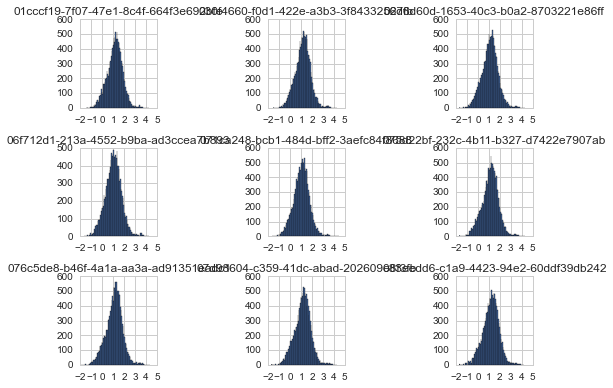

In [8]:
log_tpm.ix[:, 0:9].hist(bins=100);
plt.tight_layout()

## Clustering

In [9]:
res = cpb.analysis.SVD(log_tpm, scale_variance=True)

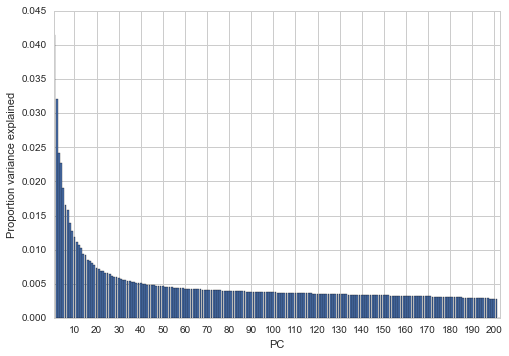

In [10]:
res.plot_variance_explained(xtick_start=10, xtick_spacing=10)

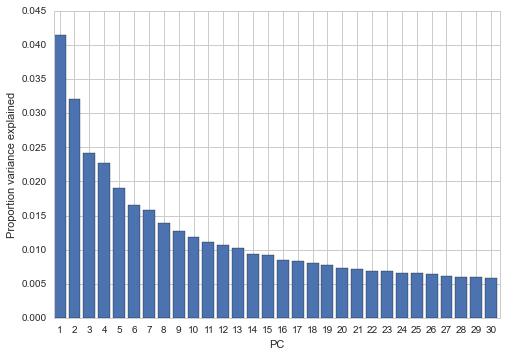

In [11]:
res.plot_variance_explained(num_pc=30)

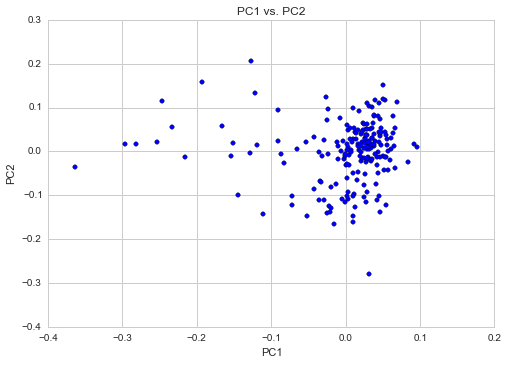

In [12]:
res.plot_pc_scatter('PC1', 'PC2')

In [ ]:
3 + 

## Normality of Expression Values

I want to see how normal the expression values are.

In [ ]:
res = stats.mstats.normaltest(vsd, axis=1)

In [ ]:
pd.Series(-1 * np.log(res[1])).hist(bins=20)
plt.ylabel('Number of genes')
plt.xlabel('$-\log$ $p$-value for test of normality');

In [ ]:
(res[1] < 0.05).sum()

It seems like a fair number of genes deviate from normality. However, when I've looked at some
genes graphically, the distributions often aren't too weird. I'm not sure whether I need to 
normalize the data (quantile, map to normal, etc.) or not.